In [47]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [48]:
model_name = "gpt2"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
model = model.to(device)

In [49]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the entire dictionary to the GPU
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [50]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    print(next_token_id)
    return next_token_id, outputs.past_key_values

In [51]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(100):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]],device=next_inputs["input_ids"].device)],
            dim=1),
        "past_key_values": past_key_values,
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

tensor(13990, device='cuda:0')
tensor(290, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
tensor(262, device='cuda:0')
tensor(584, device='cuda:0')
tensor(1735, device='cuda:0')
tensor(286, device='cuda:0')
tensor(262, device='cuda:0')
tensor(13990, device='cuda:0')
tensor(13, device='cuda:0')
tensor(679, device='cuda:0')
tensor(373, device='cuda:0')
tensor(546, device='cuda:0')
tensor(284, device='cuda:0')
tensor(1057, device='cuda:0')
tensor(618, device='cuda:0')
tensor(339, device='cuda:0')
tensor(2497, device='cuda:0')
tensor(262, device='cuda:0')
tensor(21831, device='cuda:0')
tensor(13, device='cuda:0')
tensor(679, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
tensor(262, device='cuda:0')
tensor(584, device='cuda:0')
tensor(1735, device='cuda:0')
tensor(286, device='cuda:0')
tensor(262, device='cuda:0')
tensor(13990, device='cuda:0')
tensor(290, device='cuda:0')
tensor(4966, device='cuda:0')
tensor(284, device='cuda:0')
t

In [52]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [53]:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [54]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "Samuel takes his",
    "The quick brown fox jumped over the",
    "I am only a machine, but I can",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors

inputs = tokenizer(prompts,padding=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the entire dictionary to the GPU
inputs

{'input_ids': tensor([[50256, 50256, 50256, 50256, 50256, 16305,  2731,  2753,   465],
         [50256, 50256,   464,  2068,  7586, 21831, 11687,   625,   262],
         [   40,   716,   691,   257,  4572,    11,   475,   314,   460]],
        device='cuda:0'),
 'attention_mask': tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [55]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[50256, 50256, 50256, 50256, 50256, 16305,  2731,  2753,   465],
        [50256, 50256,   464,  2068,  7586, 21831, 11687,   625,   262],
        [   40,   716,   691,   257,  4572,    11,   475,   314,   460]],
       device='cuda:0')
shape: torch.Size([3, 9])


In [56]:
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')
shape: torch.Size([3, 9])


In [57]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[1, 1, 1, 1, 1, 0, 1, 2, 3],
        [1, 1, 0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6, 7, 8]], device='cuda:0')

In [58]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [59]:
last_logits = logits[:, -1, :] 
next_token_ids = last_logits.argmax(dim=1) 

In [60]:
print(next_token_ids)

tensor([ 1295, 13990,   466], device='cuda:0')


In [61]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' place', ' fence', ' do']

In [62]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [63]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1), device=next_inputs["input_ids"].device),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [64]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [65]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

Samuel takes his  place in the middle of the room, and the

The quick brown fox jumped over the  fence and ran to the other side of the fence

I am only a machine, but I can  do it. I am a machine, but I



In [66]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move the entire dictionary to the GPU
    
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1


duration 0.12127351760864258
throughput 82.45823323333163
avg latency 0.012127351760864259

bs= 2
duration 0.08977556228637695
throughput 222.77777482697996
avg latency 0.008977556228637695

bs= 4
duration 0.09205198287963867
throughput 434.5370816433304
avg latency 0.009205198287963868

bs= 8
duration 0.1054997444152832
throughput 758.2956759126595
avg latency 0.010549974441528321

bs= 16
duration 0.11147665977478027
throughput 1435.2780243259256
avg latency 0.011147665977478027

bs= 32
duration 0.12173104286193848
throughput 2628.7460657256397
avg latency 0.012173104286193847

bs= 64
duration 0.21042203903198242
throughput 3041.506502570889
avg latency 0.02104220390319824

bs= 128
duration 0.3255493640899658
throughput 3931.815390203837
avg latency 0.03255493640899658



In [67]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [68]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

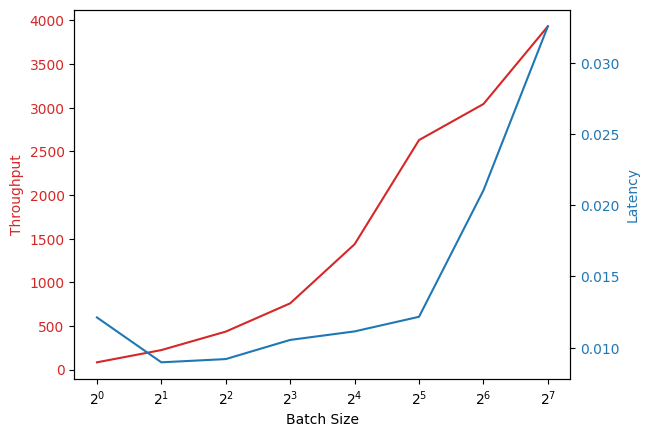

In [69]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)